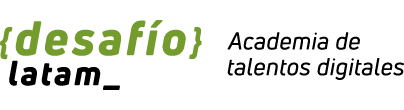

#<center><font color = 'green'>Solución Desafío - Prediciendo los precios de las casas</font></center>

Como Cientista de Datos te han contratado en una importante empresa de propiedades para analizar las diferentes características de algunas casas que se han vendido en el último tiempo, y que se encuentran en el dataset house_data.xlsx. Esta base de datos contiene diversas características de estas propiedades y su precio. Específicamente, se te solicita:


1. Analizar la calidad de datos, para lo que debes cargarlos y realizar un proceso exhaustivo de limpieza para eliminar valores faltantes, duplicados y atípicos que puedan afectar la calidad del modelo, si los hay.

2. Realizar un análisis descriptivo de las variables para entender la distribución de los datos y detectar posibles relaciones entre las características y los precios. En esto debes incluir un análisis de correlaciones entre las variables principalmente con el precio de las casas

3. Aplicar técnicas de transformación de datos, como normalización o estandarización, para asegurar que las variables estén en una escala comparable. Luego de ello, divide el conjunto de datos en conjuntos de entrenamiento y prueba de manera aleatoria o estratificada.

4. Implementar modelos de regresión lineal con regularización, como Ridge, Lasso o Elastic Net y ajuste los hiper parámetros mostrando como se mueve los hiperparametros y el ajuste. Además, debes construir modelos de árboles de regresión para capturar relaciones no lineales y complejas entre las variables predictoras y el precio de las casas.

5. Utilizar métricas de evaluación de regresión, como el Error Cuadrático Medio (MSE), el Error Absoluto Medio (MAE) y el Coeficiente de Determinación (R²), para medir el rendimiento del modelo y concluir sobre ellos.

Se muestra a continuación un modelo de resolución, que puede ser diferente en enfoque y elementos del que presenten los estudiantes.

In [ ]:
# DATA
import pandas as pd
import numpy as np

# GRAFICOS
import matplotlib.pyplot as plt
import seaborn as sns

# DATA PREPROCESSING
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import KFold

# MODELOS
import sklearn.linear_model as lm
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.linear_model import Lasso, LassoCV
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree

# METRICAS DE REGRESION
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error
import pickle

import warnings
warnings.filterwarnings('ignore')

# 1. Calidad de datos

In [ ]:
df = pd.read_excel('house_data.xlsx')

print('Numero de filas: {0}'.format(df.shape[0]))
print('Numero de columnas: {0}'.format(df.shape[1]))

Numero de filas: 21613
Numero de columnas: 21


In [ ]:
def data_quality_analysis(df):
    # Crear un nuevo dataframe para almacenar los resultados
    result_df = pd.DataFrame(columns=['Columna', 'Tipo de dato', 'Valores únicos', 'Valores faltantes'])

    # Obtener información general del dataframe
    columns = df.columns
    data_types = df.dtypes.to_list()
    unique_values = [df[column].nunique() for column in columns]
    missing_values = [df[column].isnull().sum() for column in columns]

    # Llenar el nuevo dataframe con los resultados
    result_df['Columna'] = columns
    result_df['Tipo de dato'] = data_types
    result_df['Valores únicos'] = unique_values
    result_df['Valores faltantes'] = missing_values

    return result_df

# Ejemplo de uso de la función con el dataframe 'df'
analysis_result = data_quality_analysis(df).set_index('Columna')
print(analysis_result)

              Tipo de dato  Valores únicos  Valores faltantes
Columna                                                      
id                   int64           21436                  0
date                object             372                  0
price                int64            4028                  0
bedrooms             int64              13                  0
bathrooms          float64              30                  0
sqft_living          int64            1038                  0
sqft_lot             int64            9782                  0
floors             float64               6                  0
waterfront           int64               2                  0
view                 int64               5                  0
condition            int64               5                  0
grade                int64              12                  0
sqft_above           int64             946                  0
sqft_basement        int64             306                  0
yr_built

In [ ]:
# Vamos a eliminar ciertas columnas que son irrelevantes para nuestroanalisis
df.drop(['zipcode', 'id', 'date'], axis = 1, inplace = True)

# 2. Analisis Exploratorio

In [ ]:
df.columns.shape

(18,)

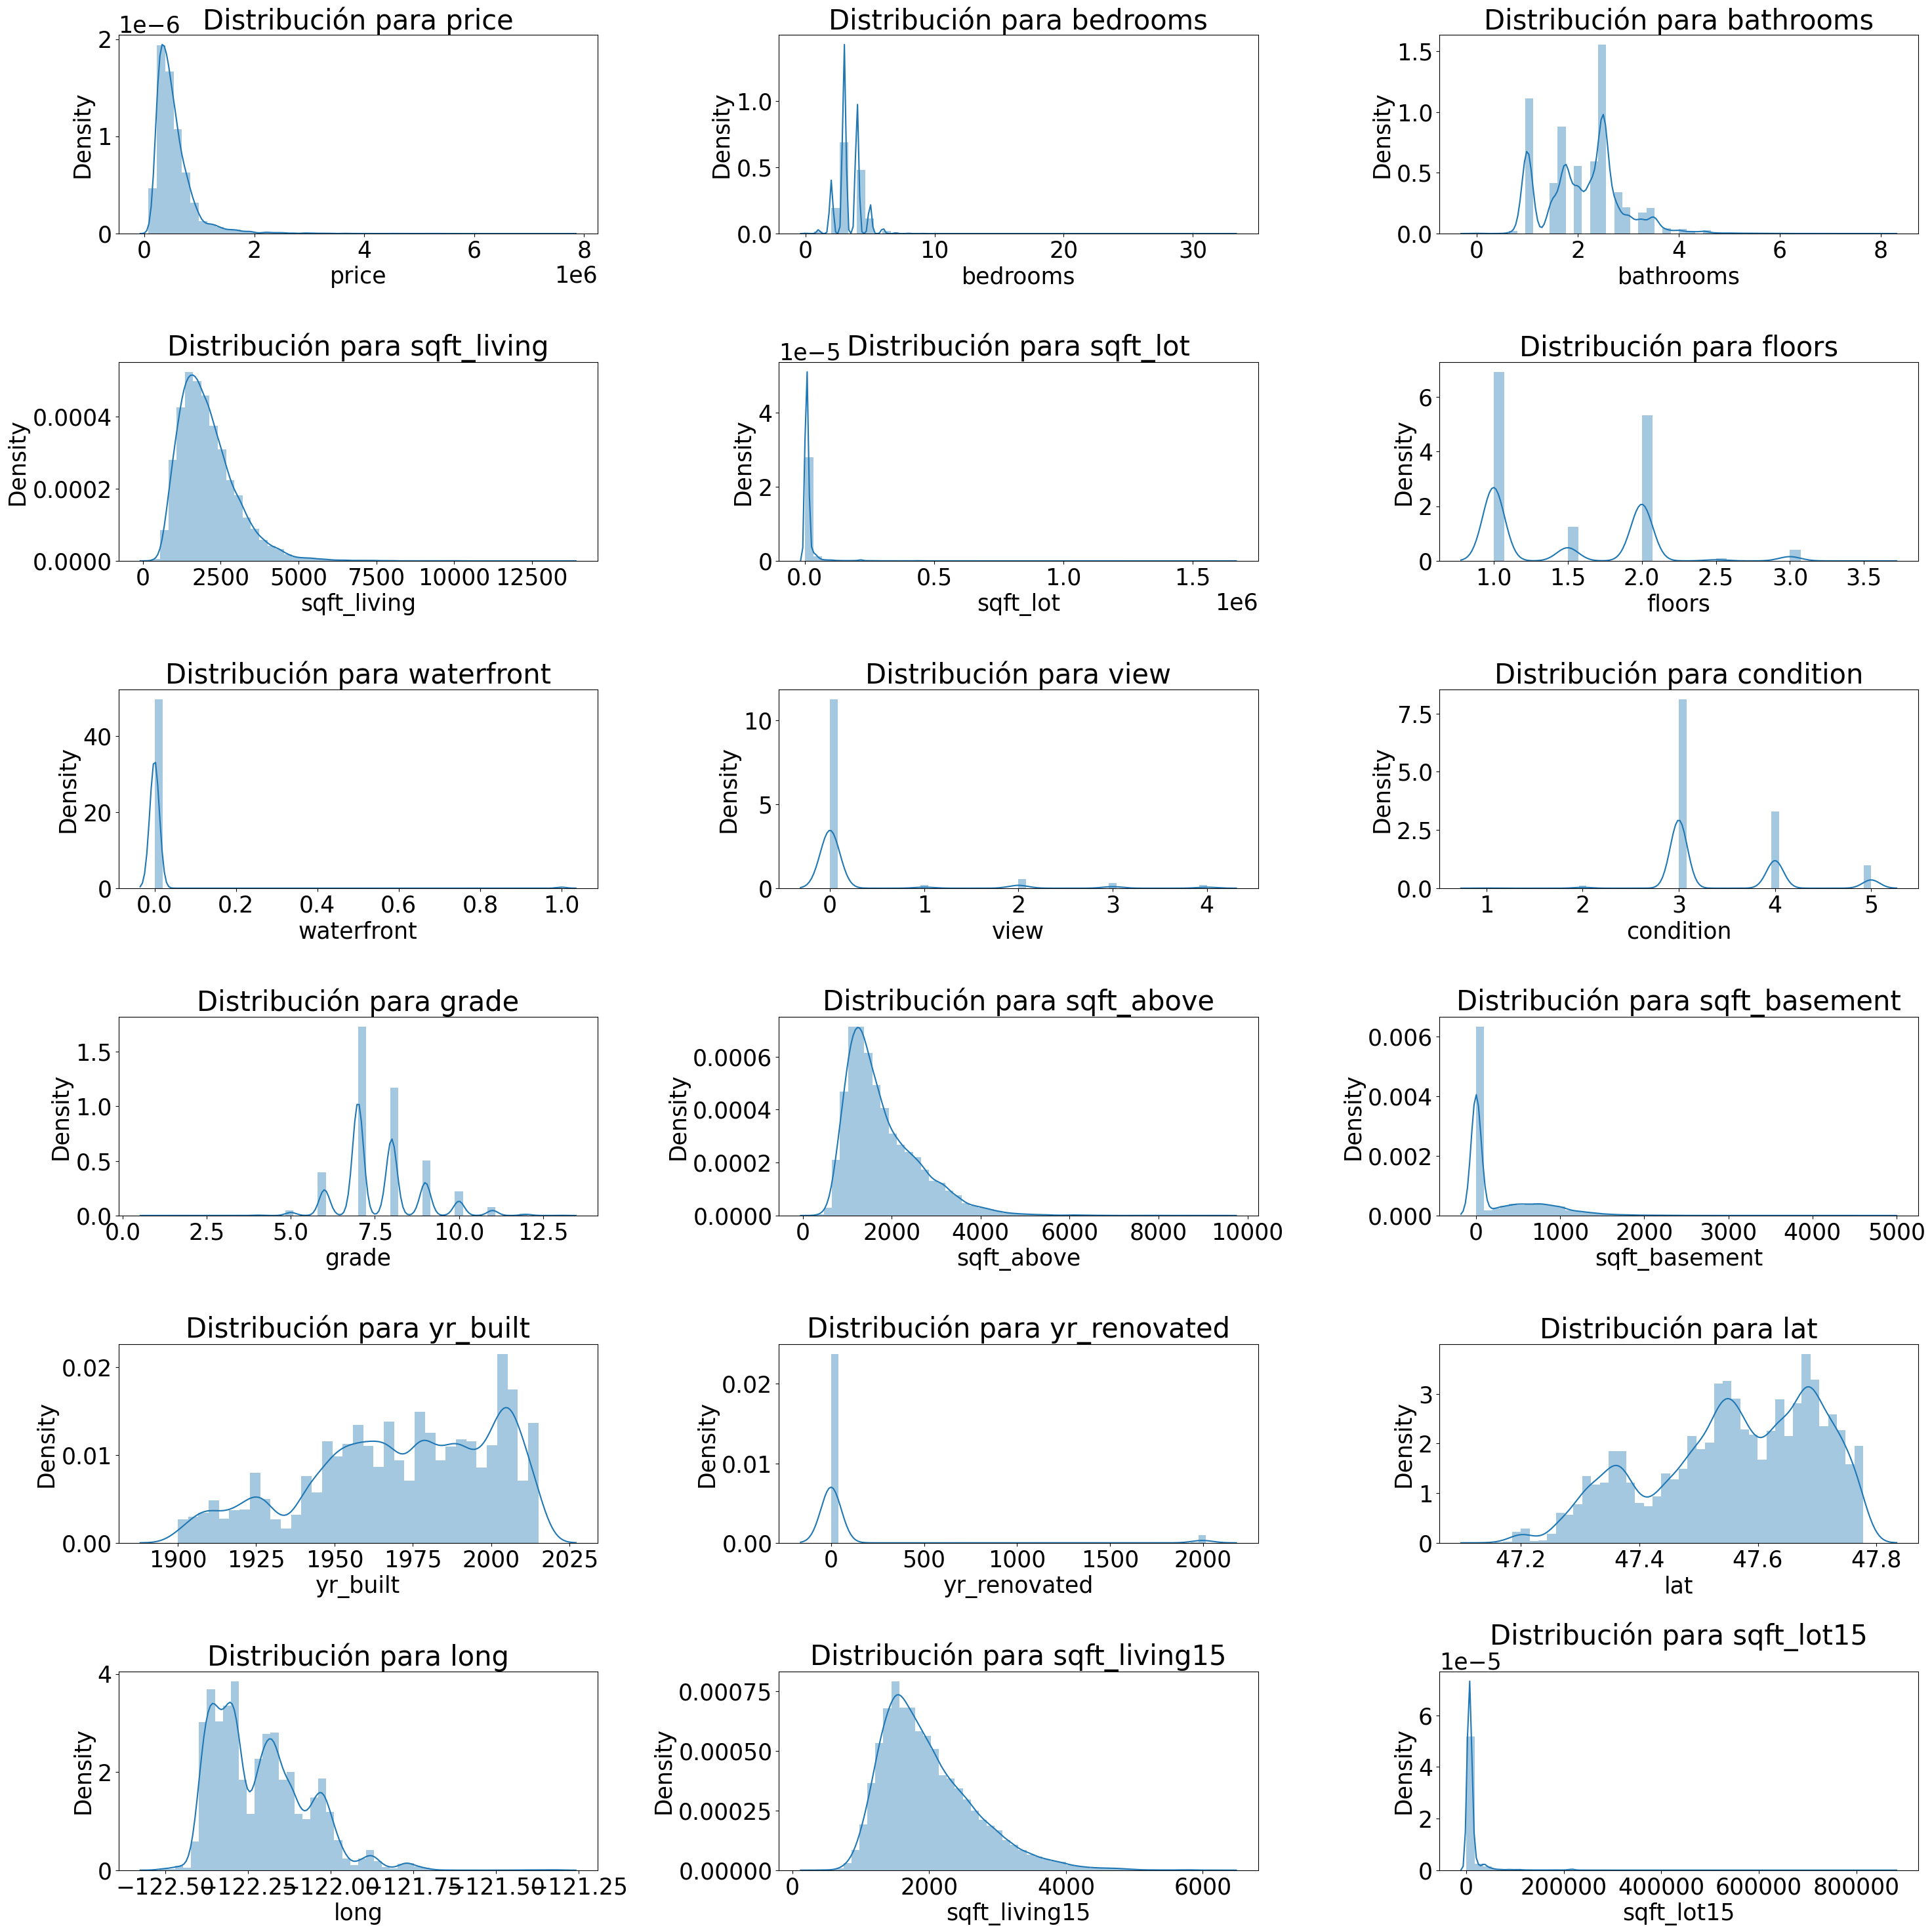

In [ ]:
plt.rcParams.update({'font.size': 25})

plt.figure(figsize=(30, 30))
for n, i in enumerate(list(df.columns)):
    plt.subplot(6, 3, n + 1)
    if analysis_result.loc[i, 'Tipo de dato']=='object':
        sns.countplot(y= df[i], order=df[i].value_counts().iloc[:7].index)
        plt.title('Frecuencias para {}'.format(i))

    else:
        sns.distplot(df[i])
        plt.title('Distribución para {}'.format(i))
    plt.tight_layout()

In [ ]:
# Normalizamos la variable precio
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns = df.columns)
df_scaled['price'] = np.log(df['price'])

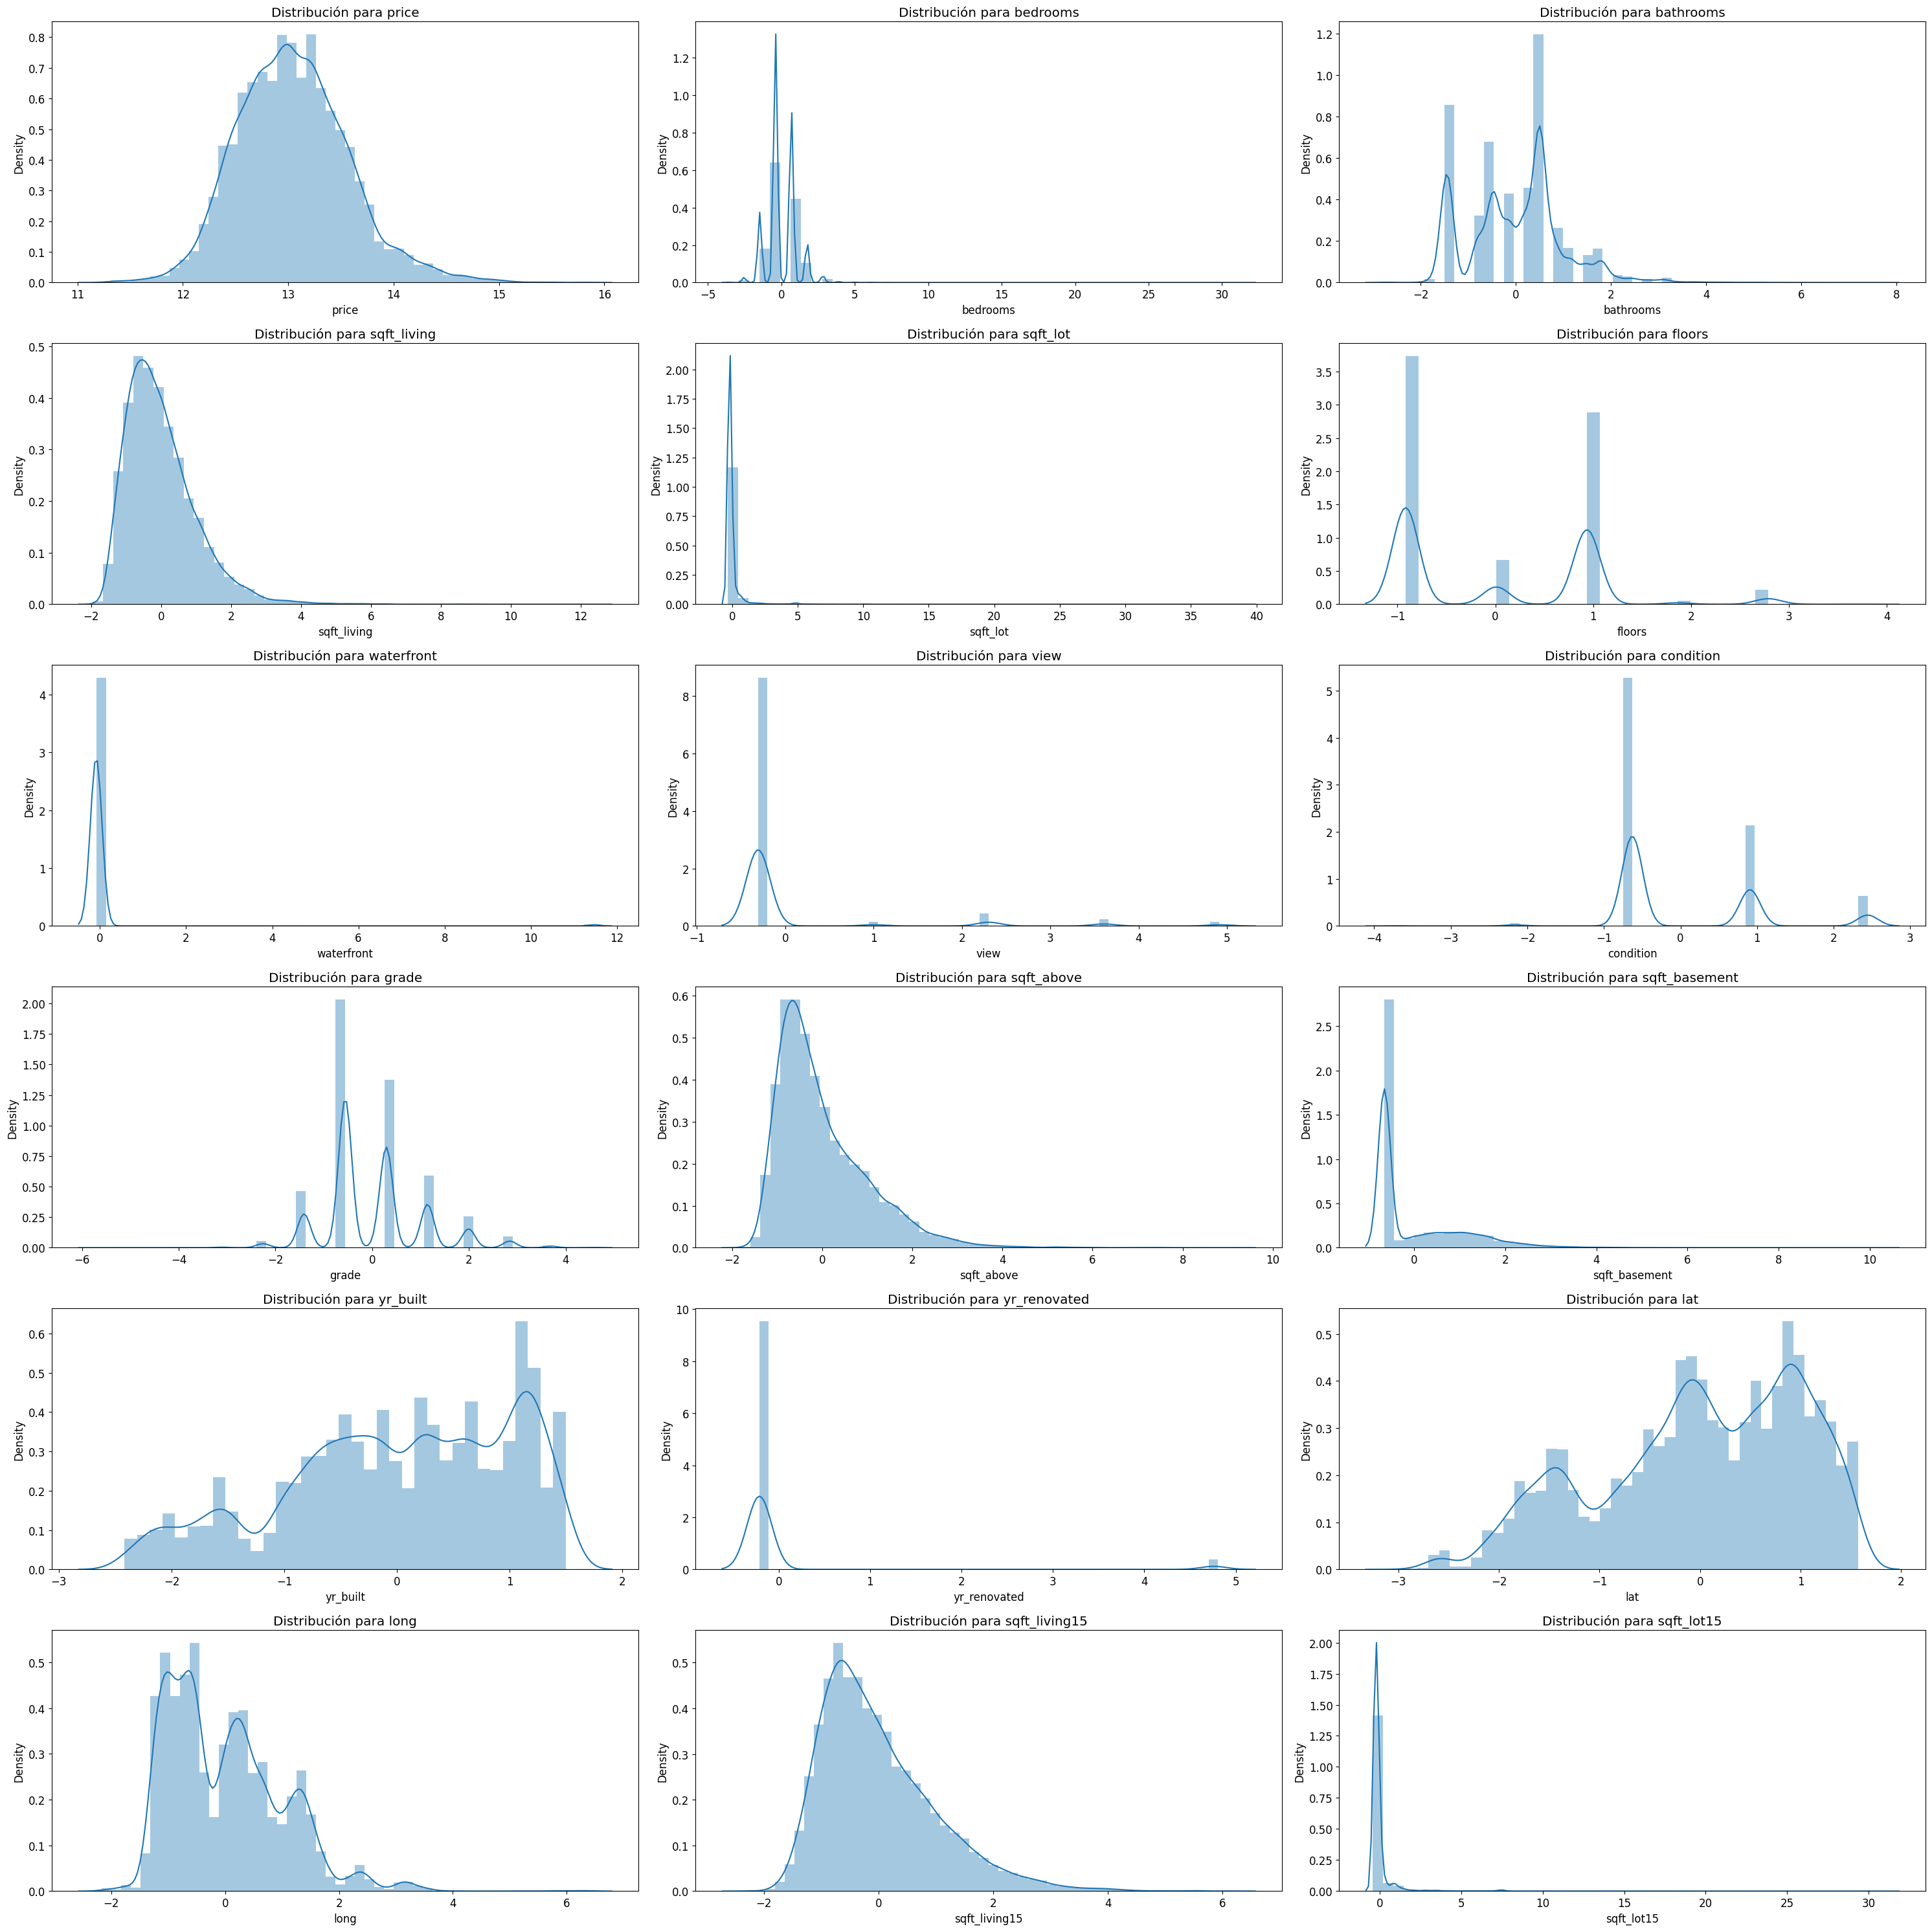

In [ ]:
plt.rcParams.update({'font.size': 12})

plt.figure(figsize=(30, 30))
for n, i in enumerate(list(df_scaled.columns)):
    plt.subplot(6, 3, n + 1)
    if analysis_result.loc[i, 'Tipo de dato']=='object':
        sns.countplot(y= df_scaled[i], order=df_scaled[i].value_counts().iloc[:7].index)
        plt.title('Frecuencias para {}'.format(i))

    else:
        sns.distplot(df_scaled[i])
        plt.title('Distribución para {}'.format(i))
    plt.tight_layout()

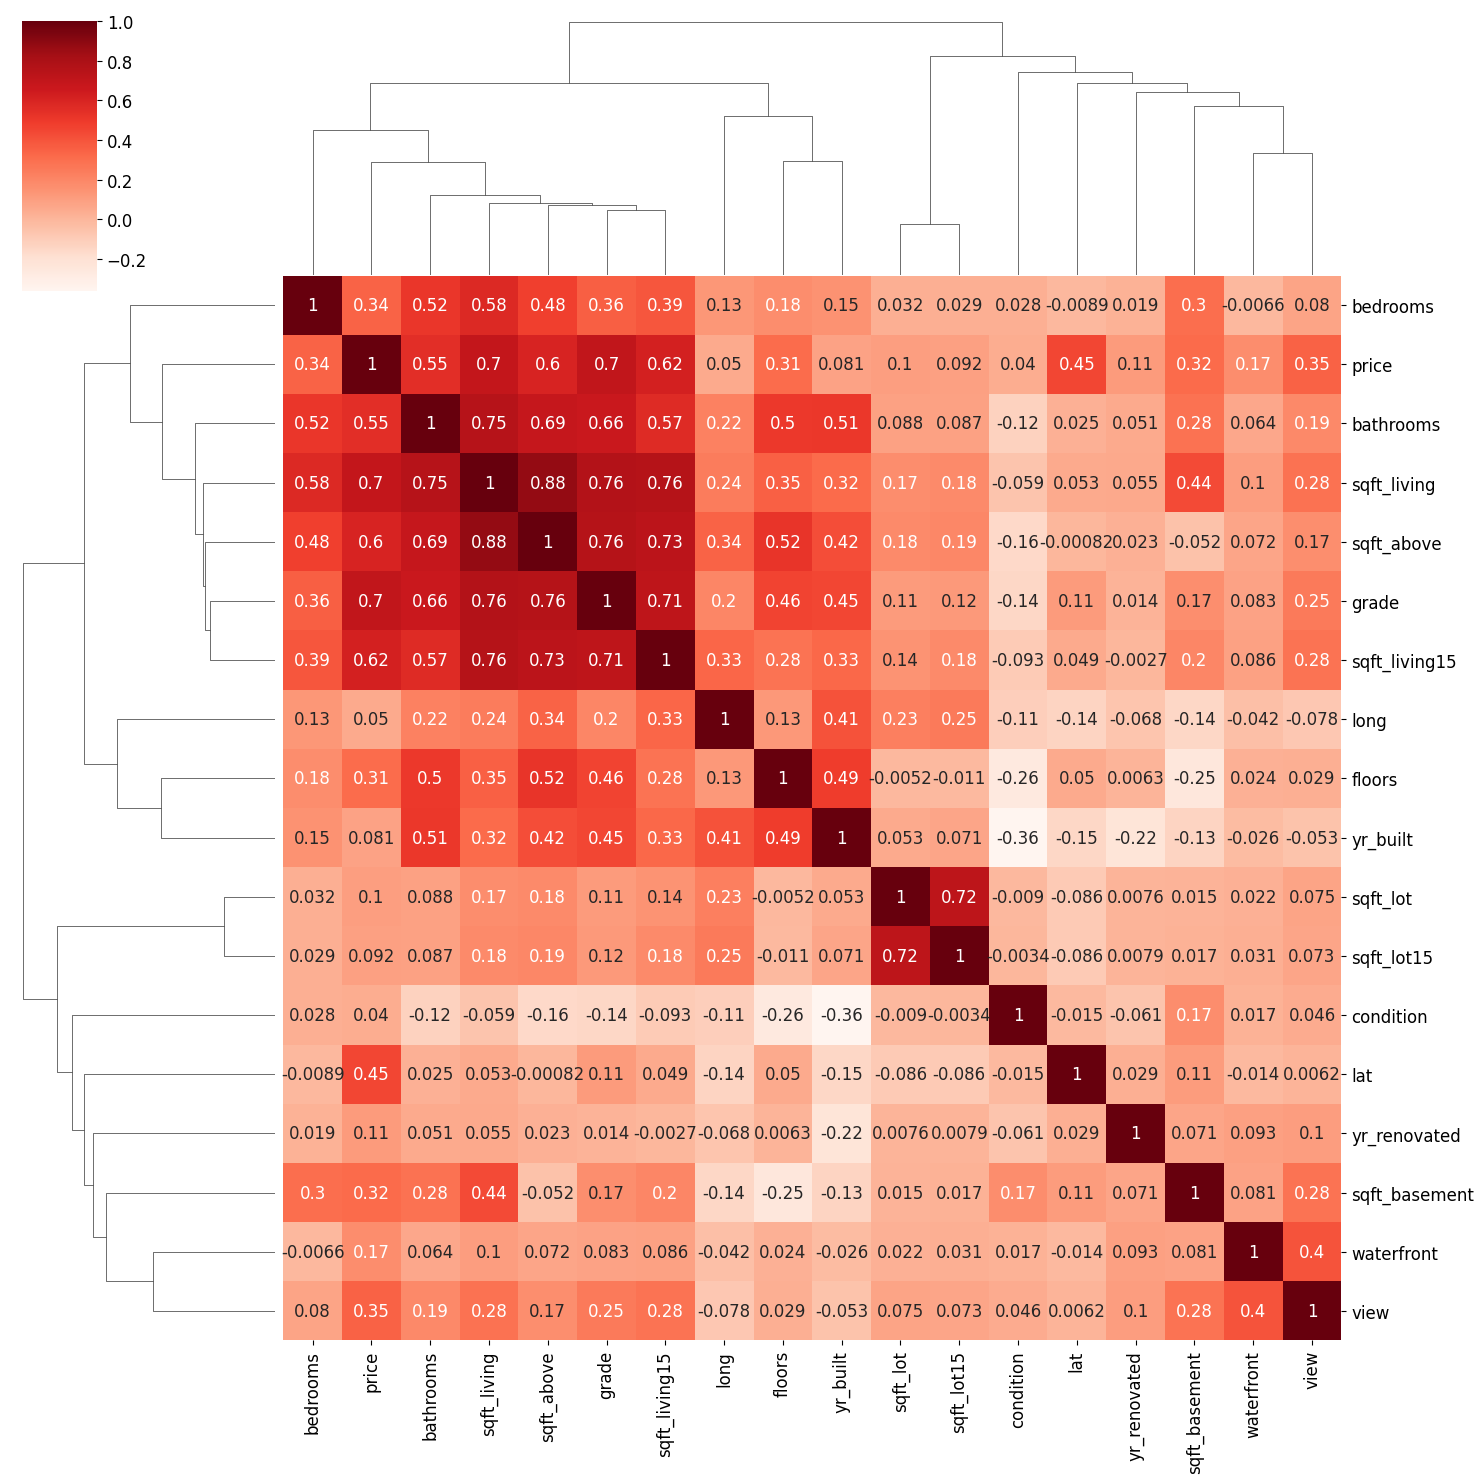

In [ ]:
plt.rcParams.update({'font.size': 12})

sns.clustermap(df_scaled.corr(), cmap='Reds', annot=True, figsize=(15,15))

<Axes: >

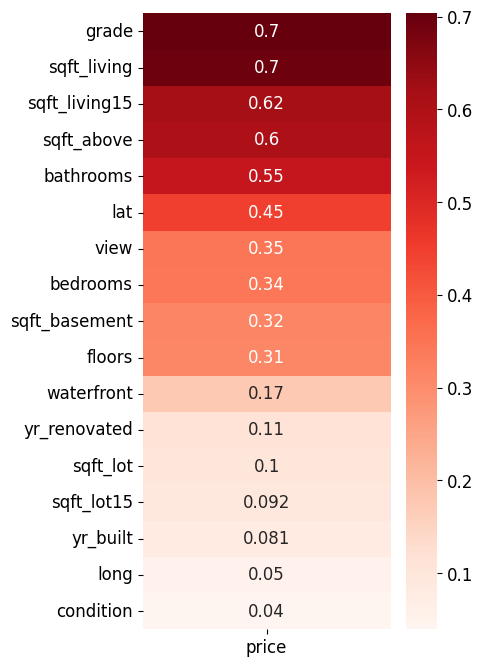

In [ ]:
plt.rcParams.update({'font.size': 12})

plt.figure(figsize=(4, 8))
sns.heatmap(df_scaled.corr().loc[:, ['price']].sort_values('price', ascending=False).iloc[1:], cmap='Reds', annot=True)


# 3. Transformacion y Split

In [ ]:
# Normalizamos la variable precio
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns = df.columns)
df_scaled['price'] = np.log(df['price'])

In [ ]:
# División del conjunto de datos en conjuntos de entrenamiento y prueba
X = df_scaled.drop('price', axis=1)
y = df_scaled['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Entrenamiento

In [ ]:
def cv_error(x_train, y_train, k, method = 'OLS', alpha = 1):

    # set training attr matrix and target
    Xm, ym = x_train, y_train
    # define kfold manual split
    kf = KFold(n_splits=k)
    # set rmse to 0
    rmse_cv = 0
    # register coefficients
    coef_v = []

    # infer model class given function argument
    if method is 'OLS':
        method_type = lm.LinearRegression(fit_intercept=False)
    elif method is 'ridge':
        method_type = lm.Ridge(alpha=alpha, fit_intercept=False)
    elif method is 'lasso':
        method_type = lm.Lasso(alpha = alpha, fit_intercept=False)
    elif method is 'enet':
        method_type = lm.ElasticNet(alpha=alpha, fit_intercept=False)
    else:
        # raise error if argument isn't valid
        raise TypeError("Method argument is not valid")

    # for each partition
    for train_index, validation_index in kf.split(Xm):
        # instantiate model
        method_type = method_type
        # fit on randomized training
        method_type.fit(Xm.iloc[train_index,], ym.iloc[train_index,])
        # append estimates
        coef_v.append(method_type.coef_)
        # create predictions
        yhat_validation = method_type.predict(Xm.iloc[validation_index])
        # update rmse metric
        rmse_cv += np.mean(np.power(np.array(yhat_validation) - np.array(ym.iloc[validation_index]), 2))

    return rmse_cv

In [ ]:
names_regressors = X_train.columns

alphas = np.logspace(0, 7, base = 10)
coefs_ridge = []
cv_err_ridge = []
model_ridge = Ridge(fit_intercept = True)

for a in alphas:
    model_ridge.set_params(alpha = a)
    model_ridge.fit(X_train, y_train)
    coefs_ridge.append(model_ridge.coef_)
    cv_err_estimates = cv_error(X_train, y_train, k = 10, method = 'ridge', alpha = a)
    cv_err_ridge.append(np.mean(cv_err_estimates))

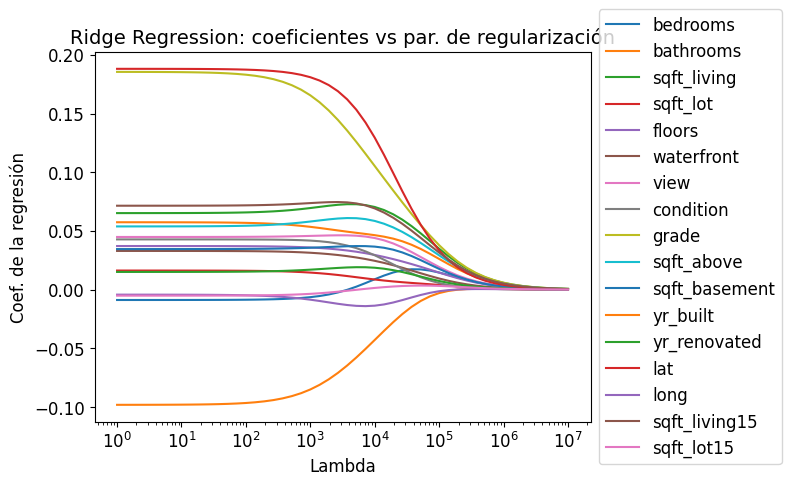

In [ ]:
names_regressors = X.columns

for y_arr, label in zip(np.squeeze(coefs_ridge).T, names_regressors):
    plt.plot(alphas, y_arr, label = label)
plt.legend()
plt.xscale("log")
plt.title("Ridge Regression: coeficientes vs par. de regularización",
size = 14)
plt.xlabel('Lambda')
plt.ylabel('Coef. de la regresión')
plt.axis("tight")
plt.legend(loc="center left", bbox_to_anchor=(1, .5));

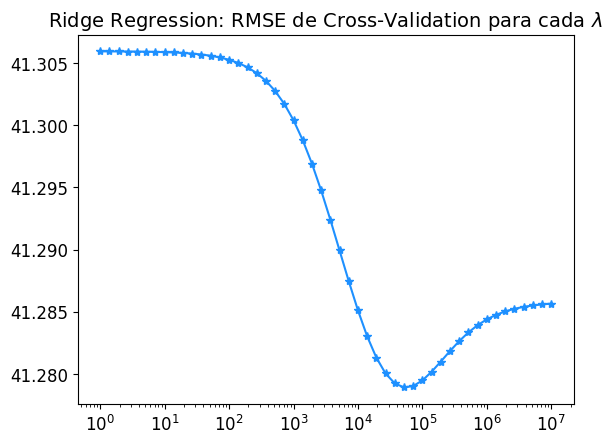

In [ ]:
plt.plot(alphas, np.sqrt(cv_err_ridge),"*-", color='dodgerblue')
plt.xscale("log")
plt.title("Ridge Regression: RMSE de Cross-Validation para cada $\lambda$", fontsize = 14);

In [ ]:
def find_best_model(X, y):
    # Definir los hiperparámetros a ajustar para cada algoritmo
    lasso_params = {'alpha': [0.001, 0.01, 0.1, 1, 10]}
    ridge_params = {'alpha': [0.001, 0.01, 0.1, 1, 10]}
    elastic_params = {'alpha': [0.001, 0.01, 0.1, 1, 10],
                      'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]}
    tree_params = {'max_depth': [None, 10, 20, 30],
                   'min_samples_split': [2, 5, 10],
                   'min_samples_leaf': [1, 2, 4]}

    # Definir los modelos
    lasso = Lasso()
    ridge = Ridge()
    elastic = ElasticNet()
    tree = DecisionTreeRegressor()

    # Realizar la búsqueda de hiperparámetros utilizando validación cruzada
    models = [lasso, ridge, elastic, tree]
    params = [lasso_params, ridge_params, elastic_params, tree_params]
    best_model = None
    best_params = None
    best_score = float('-inf')

    models_save = []

    for model, param_grid in zip(models, params):
        grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error')
        grid_search.fit(X, y)

        if grid_search.best_score_ > best_score:
            best_score = grid_search.best_score_
            best_model = model
            best_params = grid_search.best_params_
        print("Best Model: ", grid_search.best_estimator_)
        print("Best params: ", grid_search.best_params_)
        print("Ajuste: ", -grid_search.best_score_)
        print('-'*100)
        models_save.append(grid_search.best_estimator_)

    return best_model, best_params, models_save


# Ejemplo de uso con datos X_train y y_train
best_model, best_params, models = find_best_model(X_train, y_train)
print("Mejor modelo:", best_model)
print("Mejores hiperparámetros:", best_params)


Best Model:  Lasso(alpha=0.001)
Best params:  {'alpha': 0.001}
Ajuste:  0.06419748423080708
----------------------------------------------------------------------------------------------------
Best Model:  Ridge(alpha=10)
Best params:  {'alpha': 10}
Ajuste:  0.06422052715497935
----------------------------------------------------------------------------------------------------
Best Model:  ElasticNet(alpha=0.001, l1_ratio=0.9)
Best params:  {'alpha': 0.001, 'l1_ratio': 0.9}
Ajuste:  0.06419789329190248
----------------------------------------------------------------------------------------------------
Best Model:  DecisionTreeRegressor(max_depth=10, min_samples_leaf=4)
Best params:  {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2}
Ajuste:  0.04810645850636831
----------------------------------------------------------------------------------------------------
Mejor modelo: DecisionTreeRegressor()
Mejores hiperparámetros: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samp

# 5. Evaluacion

In [ ]:
def evaluation_model(model, X_test, y_test, name):
    y_predict = model.predict(X_test)
    print('R2: ', r2_score(y_predict, y_test))
    print('RMSE: ', mean_squared_error(y_predict, y_test))
    print('MAPE: ', mean_absolute_percentage_error(y_predict, y_test))
    with open(f'./{name}.pkl', 'wb') as f:
        pickle.dump(best_model, f)

In [ ]:
names = ['lasso', 'ridge', 'elastic_net', 'regresion_tree']

for n, m in zip(names, models):
    print(n)
    evaluation_model(m, X_test, y_test, n)
    print('-'*100)

lasso
R2:  0.7044057111709364
RMSE:  0.06629363729966765
MAPE:  0.015065686899034337
----------------------------------------------------------------------------------------------------
ridge
R2:  0.7071940638814356
RMSE:  0.06622121866026294
MAPE:  0.015051708585528584
----------------------------------------------------------------------------------------------------
elastic_net
R2:  0.7046773602355079
RMSE:  0.06628401383039002
MAPE:  0.015064143936328519
----------------------------------------------------------------------------------------------------
regresion_tree
R2:  0.8177817400883093
RMSE:  0.045680402732347636
MAPE:  0.011976803083166294
----------------------------------------------------------------------------------------------------
